In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from UliEngineering.EngineerIO import format_value
from si_prefix import si_format
import plecs_helper as helper
%matplotlib
%matplotlib inline

# Imports and setup
from pint import UnitRegistry
from scipy.signal import find_peaks
from scipy.optimize import fsolve

# pandas display using scientific notation
# pd.set_option('display.float_format', lambda x: f'{x:.3e}')

# use pint
units = UnitRegistry()
units.default_format = "~P.2f"

def to_decibels(arr, dc_gain = 0):
    return np.log(arr) * 20 + dc_gain

Using matplotlib backend: <object object at 0x0000023022F30520>


C:\Users\ieykamp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Lab 10
### Ian Eykamp

As expected, the output voltage jumped to a value of 9.60V and an input current of 1.30A after reaching steady state (very quickly on a human timescale). This is because the voltage divider `R2 = 4.3kOhm`, `R3 = 1.5kOhm` creates a middle node voltage of 2.5V when the input voltage is 9.67V.

For Lab 10, we used the provided feedback components `C1 = 47nF`, `R5 = 510Ohm`, and `C2 = 10nF`, with `C2` in parallel with `(C1 + R5)` in series.

This corresponds to an integrator (pole at $\omega = 0Hz$) as well as a pole-zero combination above the switching frequency (zero at $\omega = 40kHz$, pole at $\omega = 250kHz$). The dashed line shows the transfer function I recreated with these characteristics; it matches nearly perfectly with the direct equation.

The expected output voltage given the voltage divider resistors is: 9.67 V


C:\Users\ieykamp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\ieykamp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


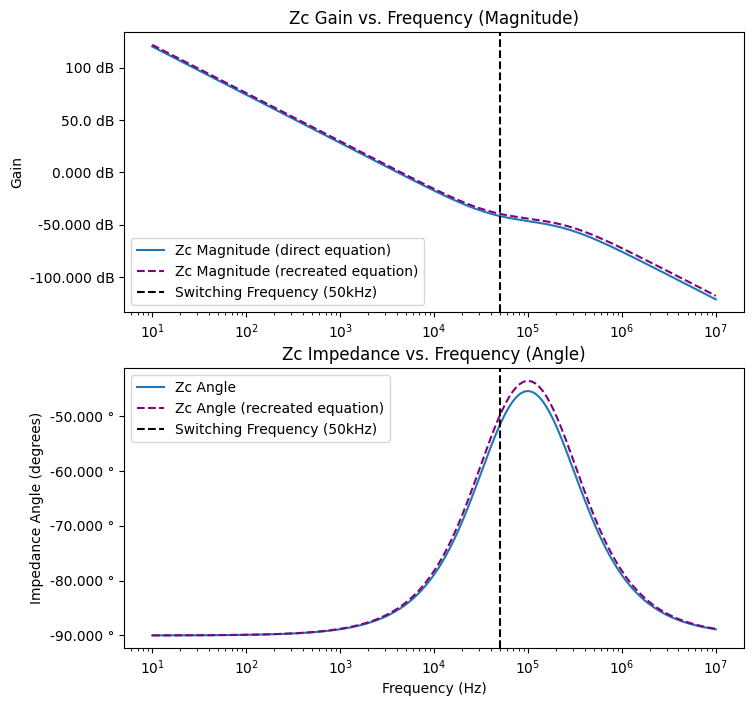

In [7]:
R2 = 4.3 # * units.kiloohm
R3 = 1.5 # * units.kiloohm
Vtarget = 2.5 * (R2 + R3) / R3 # * units.volt
print(f"The expected output voltage given the voltage divider resistors is: {si_format(Vtarget, precision = 2)}V")

C1 = 47e-9 # * units.nanofarad
C2 = 10e-9 # * units.nanofarad
R5 = 510 # * units.ohm
w = np.logspace(1, 7, 151) # * units.hertz

def get_Zc(w):
    my_Zc = 1 / (1 / (R5 + 1 / (1j * w * C1)) + 1 / (1 / (1j * w * C2))) / 4.3e3 # kOhm
    return my_Zc
Zc = get_Zc(w) # direct equation
Zc2 = (1j * w / (40e3) + 1) / ((1j * w / (1.9e7)) * (1j * w / (250e3) + 1)) / 4.3e3 # kOhm # recreated equation

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (8, 8))
helper.axes_labels("", "Hz", "Gain", "dB", title = "Zc Gain vs. Frequency (Magnitude)", ax = ax1)
ax1.semilogx(w, to_decibels(Zc), linestyle = "solid", label = "Zc Magnitude (direct equation)")
ax1.semilogx(w, to_decibels(Zc2), linestyle = "dashed", color = "purple", label = "Zc Magnitude (recreated equation)")
ax1.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax1.legend(loc = "lower left")

helper.axes_labels("Frequency (Hz)", "Hz", "Impedance Angle (degrees)", "°", title = "Zc Impedance vs. Frequency (Angle)", ax = ax2)
ax2.semilogx(w, np.angle(Zc, deg = True), linestyle = "solid", label = "Zc Angle")
ax2.semilogx(w, np.angle(Zc2, deg = True), linestyle = "dashed", color = "purple", label = "Zc Angle (recreated equation)")
ax2.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax2.legend(loc = "upper left")
# ax2.set_ylim(-100, -80)

## Bode Plots

In [3]:
# Import data
closed_loop_bode = pd.read_csv("bode_plots/closed-loop.csv")
open_loop_bode = pd.read_csv("bode_plots/open-loop.csv")
step_response_df = pd.read_csv("bode_plots/step-resp.csv")
print(closed_loop_bode.head())
# print(open_loop_bode.head())
# print(step_response_df.head())

   Frequency (Hz)  Channel 1 Magnitude (dB)  Channel 2 Magnitude (dB)  \
0      100.000000                 -0.865710                 -0.129697   
1      104.230095                 -0.860688                 -0.150814   
2      108.639127                 -0.862214                 -0.125168   
3      113.234665                 -0.830152                 -0.164857   
4      118.024599                 -0.847717                 -0.133992   

   Channel 2 Phase (deg)  
0              -0.936758  
1              -0.945141  
2              -0.892194  
3              -0.962660  
4              -1.159053  


C:\Users\ieykamp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\ieykamp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\ieykamp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


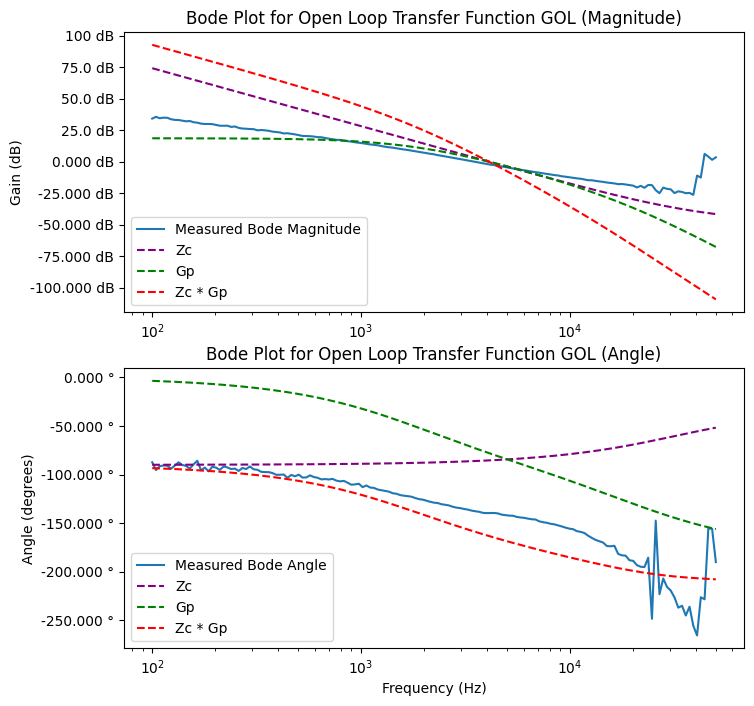

In [4]:
w = open_loop_bode["Frequency (Hz)"]
# theoretical_open_loop_bode = 1 / (w / 4e3)
Zc = get_Zc(w)
dc_gain = 18.58 # dB
G = 1 / ((w * 1j / (1.8e3)) + 1) / ((w * 1j / (2e4)) + 1)

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (8, 8))
helper.axes_labels("", "Hz", "Gain (dB)", "dB", title = "Bode Plot for Open Loop Transfer Function GOL (Magnitude)", ax = ax1)
ax1.semilogx(open_loop_bode["Frequency (Hz)"], open_loop_bode["Channel 2 Magnitude (dB)"], linestyle = "solid", label = "Measured Bode Magnitude")
ax1.semilogx(open_loop_bode["Frequency (Hz)"], to_decibels(Zc), linestyle = "dashed", color = "purple", label = "Zc")
ax1.semilogx(open_loop_bode["Frequency (Hz)"], to_decibels(G, dc_gain = dc_gain), linestyle = "dashed", color = "green", label = "Gp")
ax1.semilogx(open_loop_bode["Frequency (Hz)"], to_decibels(G * Zc, dc_gain = dc_gain), linestyle = "dashed", color = "red", label = "Zc * Gp")
ax1.legend(loc = "lower left")

helper.axes_labels("Frequency (Hz)", "Hz", "Angle (degrees)", "°", title = "Bode Plot for Open Loop Transfer Function GOL (Angle)", ax = ax2)
ax2.semilogx(open_loop_bode["Frequency (Hz)"], np.unwrap(open_loop_bode["Channel 2 Phase (deg)"], period = 360), linestyle = "solid", label = "Measured Bode Angle")
ax2.semilogx(open_loop_bode["Frequency (Hz)"], np.unwrap(np.angle(Zc, deg = True), period = 360), linestyle = "dashed", color = "purple", label = "Zc")
ax2.semilogx(open_loop_bode["Frequency (Hz)"], np.unwrap(np.angle(G, deg = True), period = 360), linestyle = "dashed", color = "green", label = "Gp")
ax2.semilogx(open_loop_bode["Frequency (Hz)"], np.unwrap(np.angle(G * Zc, deg = True), period = 360), linestyle = "dashed", color = "red", label = "Zc * Gp")
ax2.legend(loc = "lower left")

In [5]:
w = closed_loop_bode["Frequency (Hz)"] * 1j * units.hertz
theoretical_closed_loop_bode = theoretical_open_loop_bode / (1 + theoretical_open_loop_bode)
# theoretical_mag = np.log10(np.abs(theoretical_closed_loop_bode)) * 20
# theoretical_angle = np.angle(theoretical_closed_loop_bode, deg = True)

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (8, 8))
helper.axes_labels("", "Hz", "Gain (dB)", "dB", title = "Bode Plot for Closed Loop Transfer Function G (Magnitude)", ax = ax1)
ax1.semilogx(closed_loop_bode["Frequency (Hz)"], closed_loop_bode["Channel 2 Magnitude (dB)"], linestyle = "solid", label = "Measured Bode Magnitude")
ax1.semilogx(closed_loop_bode["Frequency (Hz)"], to_decibels(Zc), linestyle = "dashed", color = "purple", label = "Zc")
ax1.semilogx(closed_loop_bode["Frequency (Hz)"], to_decibels(G), linestyle = "dashed", color = "green", label = "G")
ax1.semilogx(closed_loop_bode["Frequency (Hz)"], to_decibels(G * Zc), linestyle = "dashed", color = "red", label = "Zc * G")
ax1.legend(loc = "lower left")

helper.axes_labels("Frequency (Hz)", "Hz", "Angle (degrees)", "°", title = "Bode Plot for Closed Loop Transfer Function G (Angle)", ax = ax2)
ax2.semilogx(closed_loop_bode["Frequency (Hz)"], np.unwrap(closed_loop_bode["Channel 2 Phase (deg)"], period = 360), linestyle = "solid", label = "Measured Bode Angle")
ax2.legend(loc = "lower left")

C:\Users\ieykamp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\construction.py:564: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


NameError: name 'theoretical_open_loop_bode' is not defined

# Break ----------------------------------------

C:\Users\ieykamp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\ieykamp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\ieykamp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


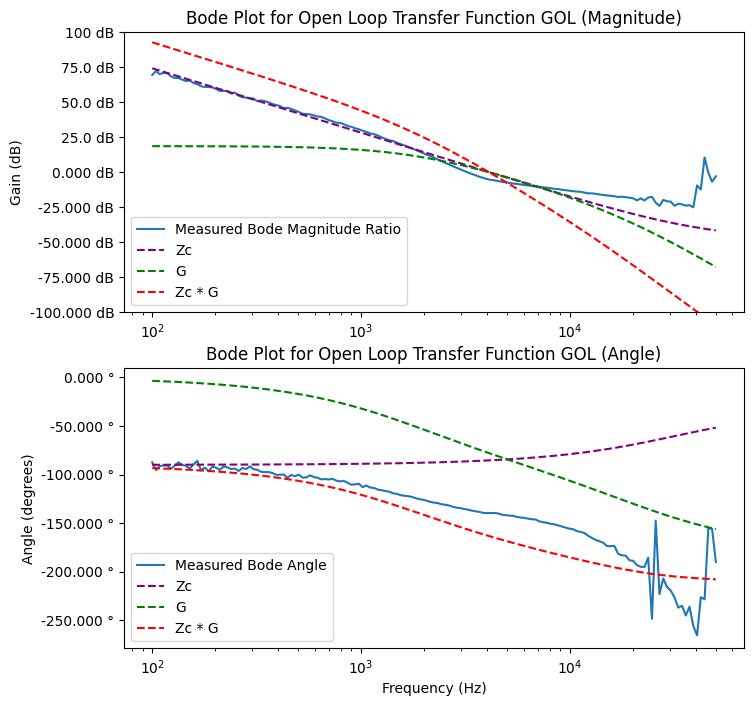

In [ ]:
w = open_loop_bode["Frequency (Hz)"]
# theoretical_open_loop_bode = 1 / (w / 4e3)
Zc = get_Zc(w)
dc_gain = 18.58 # dB
G = 1 / ((w * 1j / (1.8e3)) + 1) / ((w * 1j / (2e4)) + 1)

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (8, 8))
helper.axes_labels("", "Hz", "Gain (dB)", "dB", title = "Bode Plot for Open Loop Transfer Function GOL (Magnitude)", ax = ax1)
# ax1.semilogx(open_loop_bode["Frequency (Hz)"], open_loop_bode["Channel 2 Magnitude (dB)"], linestyle = "solid", label = "Measured Bode Magnitude CH2")
# ax1.semilogx(open_loop_bode["Frequency (Hz)"], open_loop_bode["Channel 1 Magnitude (dB)"], linestyle = "solid", label = "Measured Bode Magnitude CH1")
ax1.semilogx(open_loop_bode["Frequency (Hz)"], open_loop_bode["Channel 2 Magnitude (dB)"] - open_loop_bode["Channel 1 Magnitude (dB)"], linestyle = "solid", label = "Measured Bode Magnitude Ratio")
ax1.semilogx(open_loop_bode["Frequency (Hz)"], to_decibels(Zc), linestyle = "dashed", color = "purple", label = "Zc")
ax1.semilogx(open_loop_bode["Frequency (Hz)"], to_decibels(G, dc_gain = dc_gain), linestyle = "dashed", color = "green", label = "G")
ax1.semilogx(open_loop_bode["Frequency (Hz)"], to_decibels(G * Zc, dc_gain = dc_gain), linestyle = "dashed", color = "red", label = "Zc * G")
ax1.legend(loc = "lower left")
ax1.set_ylim(-100, 100)

helper.axes_labels("Frequency (Hz)", "Hz", "Angle (degrees)", "°", title = "Bode Plot for Open Loop Transfer Function GOL (Angle)", ax = ax2)
ax2.semilogx(open_loop_bode["Frequency (Hz)"], np.unwrap(open_loop_bode["Channel 2 Phase (deg)"], period = 360), linestyle = "solid", label = "Measured Bode Angle")
ax2.semilogx(open_loop_bode["Frequency (Hz)"], np.unwrap(np.angle(Zc, deg = True), period = 360), linestyle = "dashed", color = "purple", label = "Zc")
ax2.semilogx(open_loop_bode["Frequency (Hz)"], np.unwrap(np.angle(G, deg = True), period = 360), linestyle = "dashed", color = "green", label = "G")
ax2.semilogx(open_loop_bode["Frequency (Hz)"], np.unwrap(np.angle(G * Zc, deg = True), period = 360), linestyle = "dashed", color = "red", label = "Zc * G")
ax2.legend(loc = "lower left")